In [3]:
!pip install --quiet \
    numpy==1.26.4 \
    pandas==2.2.2 \
    matplotlib==3.9.2 \
    seaborn==0.13.2 \
    statsmodels==0.14.2 \
    scikit-learn==1.5.2 \
    prophet==1.1.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 83.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [1]:
import numpy, pandas, matplotlib, seaborn, statsmodels, sklearn
print("✅ Core libraries OK")

from prophet import Prophet
print("✅ Prophet successfully imported")

✅ Core libraries OK
✅ Prophet successfully imported


In [2]:
# 1) Imports and global settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, pickle
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# time-series libs
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Prophet (Meta). In Colab ensure prophet is installed.
try:
    from prophet import Prophet
except Exception as e:
    print('Prophet not installed or import failed:', e)
    Prophet = None

print('Imports OK')

Imports OK


In [5]:
# 2) Load dataset (expects AgriYield.csv in current working dir or adjust path)
paths_to_try = [
    '/content/AgriYield.csv',
    '/content/drive/MyDrive/AgriYield.csv',
    'crop_yield_dataset.csv'
]

df = None
for p in paths_to_try:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print('Loaded:', p)
        break

if df is None:
    raise FileNotFoundError('AgriYield.csv not found. Upload it to Colab or set path. Paths tried: ' + str(paths_to_try))

print('Shape:', df.shape)
display(df.head())

Loaded: crop_yield_dataset.csv
Shape: (36520, 12)


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,Wheat,Peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,2014-01-01,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2014-01-01,Rice,Peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
3,2014-01-01,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
4,2014-01-01,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667


In [6]:
# 3) Quick checks & basic cleaning
print(df.columns.tolist())
print('\nMissing values:')
print(df.isnull().sum())

# Ensure expected columns exist
expected_cols = ['Date','Crop_Type','Soil_Type','Soil_pH','Temperature','Humidity','Wind_Speed','N','P','K','Crop_Yield','Soil_Quality']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print('Warning: expected columns missing ->', missing)

# Convert Date to datetime (if present)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

['Date', 'Crop_Type', 'Soil_Type', 'Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality']

Missing values:
Date            0
Crop_Type       0
Soil_Type       0
Soil_pH         0
Temperature     0
Humidity        0
Wind_Speed      0
N               0
P               0
K               0
Crop_Yield      0
Soil_Quality    0
dtype: int64


In [7]:
# 4) Regression: prepare features & target for supervised model
# We'll use numerical features: Soil_pH, Temperature, Humidity, Wind_Speed, N, P, K, Soil_Quality
num_features = [c for c in ['Soil_pH','Temperature','Humidity','Wind_Speed','N','P','K','Soil_Quality'] if c in df.columns]
print('Numerical features:', num_features)

reg_df = df.dropna(subset=num_features + ['Crop_Yield']).copy()
X = reg_df[num_features]
y = reg_df['Crop_Yield']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

Numerical features: ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Soil_Quality']
Train/Test shapes: (29216, 8) (7304, 8)


In [8]:
# 5) Train Linear Regression and evaluate
reg = LinearRegression()
reg.fit(X_train, y_train)

pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f'Regression -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')

# Save regression model
os.makedirs('models', exist_ok=True)
joblib.dump(reg, 'models/agri_regression.joblib')
with open('models/agri_regression.pkl', 'wb') as f:
    pickle.dump(reg, f)
print('Saved regression model to models/agri_regression.(joblib|pkl)')

Regression -> MAE: 11.9813, RMSE: 15.3725, R2: 0.6456
Saved regression model to models/agri_regression.(joblib|pkl)


In [9]:
# 6) Time series: prepare daily (or available frequency) series for Crop_Yield
if 'Date' not in df.columns:
    raise RuntimeError('Date column missing - time series steps require Date column')

ts = df[['Date','Crop_Yield']].dropna().copy()
# set index
ts = ts.set_index('Date').sort_index()

# Resample to daily and compute mean (will create gaps if no data for date)
ts_daily = ts.resample('D').mean()
print('TS daily shape:', ts_daily.shape)
display(ts_daily.head())

TS daily shape: (3652, 1)


,Crop_Yield
Date,
2014-01-01,37.073799
2014-01-02,34.636737
2014-01-03,22.107670
2014-01-04,28.197627
2014-01-05,26.062550


Series length: 3652

ADF test statistic: -6.2367, p-value: 4.807e-08
KPSS statistic: 0.0190, p-value: 0.1


/tmp/ipython-input-3828046002.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression='c', nlags='auto')


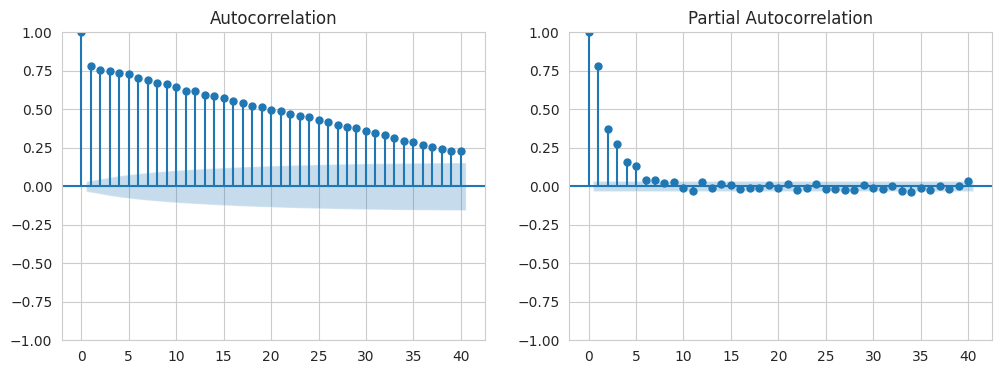

In [10]:
# 7) Stationarity tests: ADF and KPSS
series = ts_daily['Crop_Yield'].dropna()
print('Series length:', len(series))

adf_res = adfuller(series)
print('\nADF test statistic: %.4f, p-value: %.4g' % (adf_res[0], adf_res[1]))

try:
    kpss_res = kpss(series, regression='c', nlags='auto')
    print('KPSS statistic: %.4f, p-value: %.4g' % (kpss_res[0], kpss_res[1]))
except Exception as e:
    print('KPSS error (maybe too short or other):', e)

# ACF/PACF plots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_acf(series, lags=40, ax=axes[0])
plot_pacf(series, lags=40, ax=axes[1])
plt.show()

SARIMAX training length: 3652


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                        Crop_Yield   No. Observations:                 3652
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -12106.207
Date:                           Wed, 12 Nov 2025   AIC                          24236.414
Time:                                   14:28:30   BIC                          24310.821
Sample:                               01-01-2014   HQIC                         24262.915
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Soil_pH        -4.2359      0.381    -11.104      0.000      -4.984      -3.488
Temperature     1.3231      0.091     14

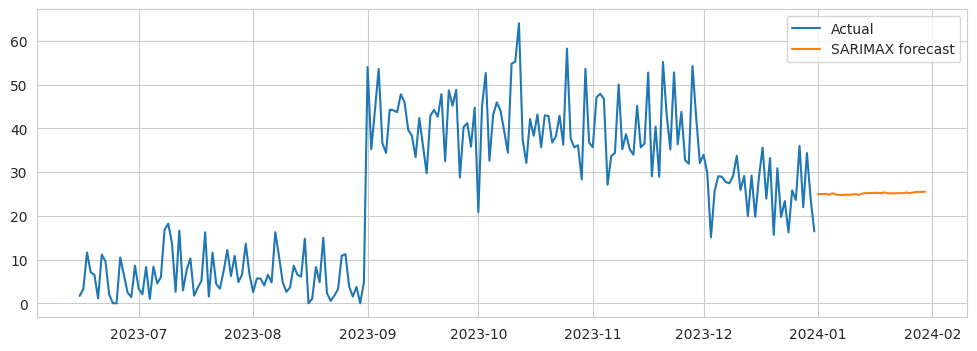

Saved SARIMAX model to models/agri_sarimax.(joblib|pkl)


In [11]:
# 8) SARIMAX with exogenous regressors (use numeric features averaged per day)
# Build exog from numeric features aggregated per day
exog_cols = [c for c in num_features if c != 'Soil_Quality']  # avoid Soil_Quality if it's continuous already
if len(exog_cols)==0:
    print('No exog columns found, SARIMAX will run without exog')

# aggregate numeric features per day
exo = df.set_index('Date').resample('D')[exog_cols].mean()
exo = exo.reindex(ts_daily.index)

# Drop days with NaN in series
mask = ~ts_daily['Crop_Yield'].isna()
series_trim = ts_daily['Crop_Yield'][mask]
exo_trim = exo[mask]

print('SARIMAX training length:', len(series_trim))

# Fit SARIMAX (small order first; increase if needed)
model_sarimax = SARIMAX(series_trim, exog=exo_trim, order=(1,0,1), seasonal_order=(1,0,1,7), enforce_stationarity=False, enforce_invertibility=False)
res_sarimax = model_sarimax.fit(disp=False)
print(res_sarimax.summary())

# Forecast next 30 days using last exog mean values
steps = 30
last_exog = exo_trim.tail(1).values
future_exog = np.repeat(last_exog, steps, axis=0)
pred_sarimax = res_sarimax.get_forecast(steps=steps, exog=future_exog)
pred_mean = pred_sarimax.predicted_mean

# Plot
plt.figure(figsize=(12,4))
plt.plot(series_trim.index[-200:], series_trim.values[-200:], label='Actual')
plt.plot(pd.date_range(series_trim.index[-1]+pd.Timedelta(days=1), periods=steps), pred_mean, label='SARIMAX forecast')
plt.legend()
plt.show()

# Save SARIMAX model
joblib.dump(res_sarimax, 'models/agri_sarimax.joblib')
with open('models/agri_sarimax.pkl','wb') as f:
    pickle.dump(res_sarimax, f)
print('Saved SARIMAX model to models/agri_sarimax.(joblib|pkl)')

In [18]:
!pip uninstall -y prophet fbprophet pystan cmdstanpy
!pip install prophet==1.1.5 cmdstanpy==1.2.4

Found existing installation: prophet 1.1.5
Uninstalling prophet-1.1.5:
  Successfully uninstalled prophet-1.1.5
Found existing installation: cmdstanpy 1.2.0
Uninstalling cmdstanpy-1.2.0:
  Successfully uninstalled cmdstanpy-1.2.0
  Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 3.1 MB/s eta 0:00:00
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)
  Attempting uninstall: stanio
    Found existing installation: stanio 0.3.0
    Uninstalling stanio-0.3.0:
      Successfully uninstalled stanio-0.3.0


In [2]:
!pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >

In [1]:
from cmdstanpy import install_cmdstan, cmdstan_path
install_cmdstan()
print("✅ CmdStan path:", cmdstan_path())

from prophet import Prophet
print("✅ Prophet imported successfully")

DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


CmdStan install directory: /root/.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation
✅ CmdStan path: /root/.cmdstan/cmdstan-2.37.0
✅ Prophet imported successfully


In [16]:
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmp6afdmbtp
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.
Installed cmdstan-2.37.0
Test model compilation


True

In [4]:
import pandas as pd

df = pd.read_csv("crop_yield_dataset.csv")
print(df.head())

         Date Crop_Type Soil_Type  Soil_pH  Temperature   Humidity  \
0  2014-01-01     Wheat     Peaty     5.50     9.440599  80.000000   
1  2014-01-01      Corn     Loamy     6.50    20.052576  79.947424   
2  2014-01-01      Rice     Peaty     5.50    12.143099  80.000000   
3  2014-01-01    Barley     Sandy     6.75    19.751848  80.000000   
4  2014-01-01   Soybean     Peaty     5.50    16.110395  80.000000   

   Wind_Speed     N     P     K  Crop_Yield  Soil_Quality  
0   10.956707  60.5  45.0  31.5    0.000000     22.833333  
1    8.591577  84.0  66.0  50.0  104.871310     66.666667  
2    7.227751  71.5  54.0  38.5    0.000000     27.333333  
3    2.682683  50.0  40.0  30.0   58.939796     35.000000  
4    7.696070  49.5  45.0  38.5   32.970413     22.166667  


In [7]:
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'].dtype)

datetime64[ns]


In [9]:
import matplotlib.pyplot as plt

In [13]:
import joblib, pickle

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5j7ipdes/h6tayt6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5j7ipdes/u46tzmdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25988', 'data', 'file=/tmp/tmp5j7ipdes/h6tayt6g.json', 'init=/tmp/tmp5j7ipdes/u46tzmdq.json', 'output', 'file=/tmp/tmp5j7ipdes/prophet_model14dl101c/prophet_model-20251112151947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

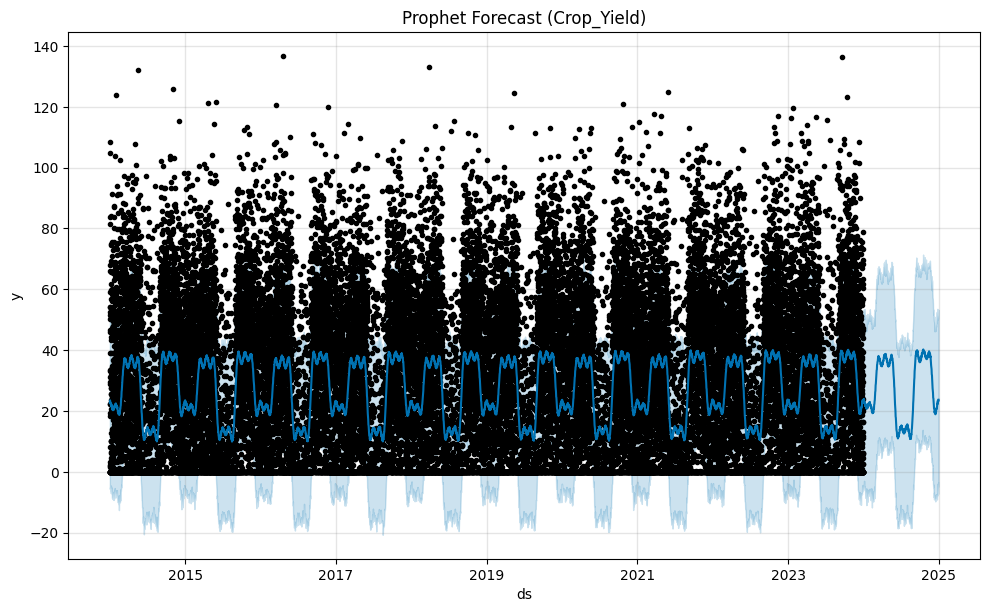

Saved Prophet model to models/agri_prophet.(joblib|pkl)


In [14]:
# 9) Prophet forecasting (with optional regressors)
if Prophet is None:
    print('Prophet not available; skip Prophet steps. Install prophet in Colab if needed.')
else:
    # Prepare prophet dataframe
    df_prop = df[['Date','Crop_Yield']].dropna().rename(columns={'Date':'ds','Crop_Yield':'y'})

    # Add exogenous regressor (example: Temperature daily mean) if available
    if 'Temperature' in df.columns:
        temp = df.set_index('Date').resample('D')['Temperature'].mean().reindex(df_prop['ds']).values
        df_prop['Temperature'] = temp
        use_reg = True
    else:
        use_reg = False

    m = Prophet()
    if use_reg:
        m.add_regressor('Temperature')
    m.fit(df_prop)

    future = m.make_future_dataframe(periods=365)  # predict 1 year ahead
    if use_reg:
        # set future Temperature to recent mean
        future['Temperature'] = df_prop['Temperature'].mean()
    forecast = m.predict(future)
    fig = m.plot(forecast)
    plt.title('Prophet Forecast (Crop_Yield)')
    plt.show()

    # Save Prophet
    joblib.dump(m, 'models/agri_prophet.joblib')
    with open('models/agri_prophet.pkl','wb') as f:
        pickle.dump(m, f)
    print('Saved Prophet model to models/agri_prophet.(joblib|pkl)')

In [15]:
# 10) Summary of saved files
import os
print('\nSaved model files:')
for f in os.listdir('models'):
    print('-', f)

print('\nYou can download these files from Colab (Files pane) or copy to Drive if needed:')
# example to copy to Drive (uncomment in Colab):
# !cp -r models /content/drive/MyDrive/AgriYield_models



Saved model files:
- agri_prophet.joblib
- agri_regression.pkl
- agri_sarimax.joblib
- agri_sarimax.pkl
- agri_prophet.pkl
- agri_regression.joblib

You can download these files from Colab (Files pane) or copy to Drive if needed:
